In [42]:
import os


def warn(*args, **kwargs):
    pass


import warnings

warnings.warn = warn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from pickle import dump

In [43]:
folders = ['vm/5high-5low/0iid', 'vm/5high-5low/40iid', 'vm/5high-5low/100iid']
exp_data: pd.DataFrame = pd.DataFrame()

for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df = df[df['Val F1'] >= 0]
            df['N. Clients'] = df['Client ID'].to_string().split('Client ')[1].split('\n')[0]
            df['Previous Val F1'] = df.shift(1)['Val F1']
            df['Previous F1/Time'] = df.shift(1)['F1/Time']
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])
            df = df[df['FL Round'] > 1]
            df['Selector'] = df['N. Clients'].apply(lambda n: int(n) == 10)
            df = df[['IID Data', 'Selector', 'Total Time of FL Round', 'Previous F1/Time', 'Previous Val F1', 'F1/Time',
                     'Val F1']]
            exp_data = pd.concat([exp_data, df])

print(exp_data)

    IID Data  Selector  Total Time of FL Round  Previous F1/Time  \
9          0     False                   99.88          0.000658   
19         0     False                  116.77          0.002000   
29         0     False                  116.74          0.002102   
39         0     False                  119.32          0.002330   
49         0     False                  114.07          0.002492   
..       ...       ...                     ...               ...   
79       100     False                   55.22          0.009600   
84       100     False                   55.81          0.009710   
89       100     False                   54.99          0.009570   
94       100     False                   55.89          0.009945   
99       100     False                   54.72          0.009764   

    Previous Val F1   F1/Time  Val F1  
9            0.0709  0.002000  0.1998  
19           0.1998  0.002102  0.2454  
29           0.2454  0.002330  0.2720  
39           0.2720  0.

In [44]:
x_train = exp_data[['IID Data', 'Selector', 'Previous Val F1']]
y_train = exp_data[['Total Time of FL Round', 'Val F1']]

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.01)
model_f1 = LinearRegression()
model_f1.fit(x_train, y_train)

with open("../predictors/f1_linear_regressor.pkl", "wb") as f:
    dump(model_f1, f, protocol=5)

tree_f1 = DecisionTreeRegressor(max_depth=20)
tree_f1.fit(x_train, y_train)

with open("../predictors/f1_tree_regressor.pkl", "wb") as f:
    dump(tree_f1, f, protocol=5)
    
x_train = exp_data[['IID Data', 'Selector', 'Previous F1/Time']]
y_train = exp_data[['Total Time of FL Round', 'F1/Time']]

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.01)
model_f1overtime = LinearRegression()
model_f1overtime.fit(x_train, y_train)

with open("../predictors/f1overtime_linear_regressor.pkl", "wb") as f:
    dump(model_f1overtime, f, protocol=5)

tree_f1overtime = DecisionTreeRegressor(max_depth=20)
tree_f1overtime.fit(x_train, y_train)

with open("../predictors/f1overtime_tree_regressor.pkl", "wb") as f:
    dump(tree_f1overtime, f, protocol=5)

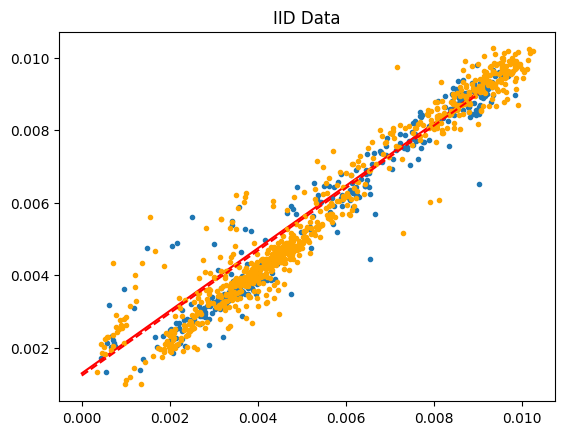

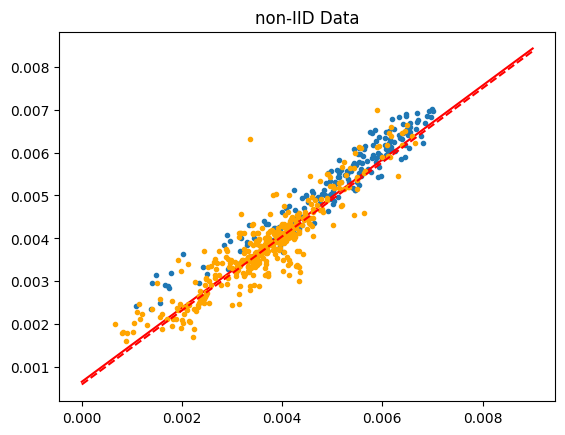

In [45]:
x = np.arange(0, 0.01, 0.001)
plot_data = exp_data[['IID Data', 'Selector', 'Previous F1/Time', 'F1/Time']].values.tolist()

plt.figure()

x_train = [i[2] for i in plot_data if i[0] and i[1]]
y_train = [i[3] for i in plot_data if i[0] and i[1]]
plt.plot(x_train, y_train, '.')
plt.plot(x, [model_f1overtime.predict([[100, True, v]])[0][1] for v in x], color='red')

x_train = [i[2] for i in plot_data if i[0] and not i[1]]
y_train = [i[3] for i in plot_data if i[0] and not i[1]]
plt.plot(x_train, y_train, '.', color='orange')
plt.plot(x, [model_f1overtime.predict([[100, False, v]])[0][1] for v in x], '--', color='red')

plt.title('IID Data')
# plt.ylim(0, 0.007)

plt.show()

plt.figure()

x_train = [i[2] for i in plot_data if not i[0] and i[1]]
y_train = [i[3] for i in plot_data if not i[0] and i[1]]
plt.plot(x_train, y_train, '.')
plt.plot(x, [model_f1overtime.predict([[0, True, v]])[0][1] for v in x], color='red')

x_train = [i[2] for i in plot_data if not i[0] and not i[1]]
y_train = [i[3] for i in plot_data if not i[0] and not i[1]]
plt.plot(x_train, y_train, '.', color='orange')
plt.plot(x, [model_f1overtime.predict([[0, False, v]])[0][1] for v in x], '--', color='red')

plt.title('non-IID Data')
# plt.ylim(0, 0.007)

plt.show()

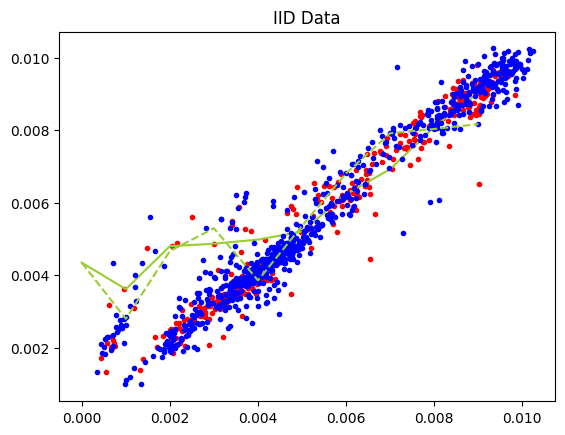

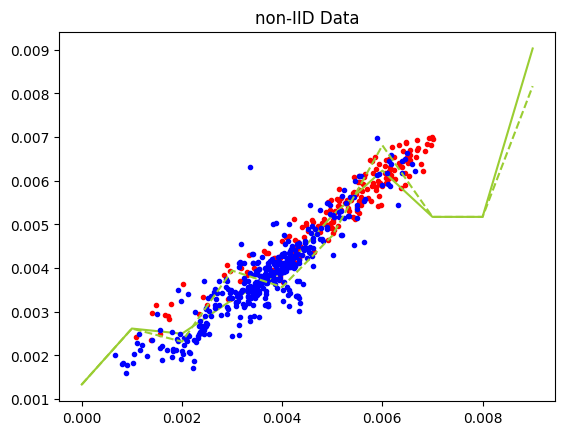

In [48]:
plt.figure()

x_train = [i[2] for i in plot_data if i[0] and i[1]]
y_train = [i[3] for i in plot_data if i[0] and i[1]]
plt.plot(x_train, y_train, '.', color='red')
plt.plot(x, [tree_f1overtime.predict([[100, True, v]])[0][1] for v in x], color="yellowgreen")

x_train = [i[2] for i in plot_data if i[0] and not i[1]]
y_train = [i[3] for i in plot_data if i[0] and not i[1]]
plt.plot(x_train, y_train, '.', color='blue')
plt.plot(x, [tree_f1overtime.predict([[100, False, v]])[0][1] for v in x], '--', color="yellowgreen")

plt.title('IID Data')
# plt.ylim(0, 0.007)

plt.show()

plt.figure()

x_train = [i[2] for i in plot_data if not i[0] and i[1]]
y_train = [i[3] for i in plot_data if not i[0] and i[1]]
plt.plot(x_train, y_train, '.', color='red')
plt.plot(x, [tree_f1overtime.predict([[40, True, v]])[0][1] for v in x], color="yellowgreen")

x_train = [i[2] for i in plot_data if not i[0] and not i[1]]
y_train = [i[3] for i in plot_data if not i[0] and not i[1]]
plt.plot(x_train, y_train, '.', color='blue')
plt.plot(x, [tree_f1overtime.predict([[40, False, v]])[0][1] for v in x], '--', color="yellowgreen")

plt.title('non-IID Data')
# plt.ylim(0, 0.007)

plt.show()